# Explore BPZ photo-z's using friends-of-friends catalog matching

Owners: HyeYun Park, Bela Abolfathi, Imran Hasan, Erfan Nourbakhsh, Adam Broussard  <br>
Last Verified to Run: 2019-01-02

This notebook is adapted from `matching_fof.ipynb` to test the performance of photo-z's derived from BPZ. See the  `object_gcr_4_photoz.ipynb` notebook for  a more in-depth tutorial on how to access the photo-z data.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.style.use('seaborn-poster')

In [3]:
import FoFCatalogMatching
import GCRCatalogs
from astropy.table import Table
import pandas as pd

## Get DC2 1.2i Data

In [4]:
#Load the DC2 object catalog, with BPZ photo-z's in the `photoz_mode` column.
object_cat =  GCRCatalogs.load_catalog('dc2_object_run1.2i_with_photoz')

In [ ]:
#all columns catalog so we can do WL cuts
catalog = GCRCatalogs.load_catalog('dc2_object_run1.2i_all_columns')

In [ ]:
from GCR import GCRQuery
star_sprinkled_filter = [
    ~GCRQuery('star'),
    ~GCRQuery('sprinkled'),
    ~GCRQuery('agn')
]

In [ ]:
# Let's also define a magnitude cut based on LSST gold sample.

mag_filters = [
    (np.isfinite, 'mag_i'),
    'mag_i < 25.0',
]

In [ ]:
#basic cuts
basic_cuts = [
    GCRQuery('extendedness > 0'),     # Extended objects
    GCRQuery((np.isfinite, 'mag_i')), # Select objects that have i-band magnitudes
    GCRQuery('clean'), # The source has no flagged pixels (interpolated, saturated, edge, clipped...) 
                       # and was not skipped by the deblender
    GCRQuery('xy_flag == 0') # Bad centroiding
]

In [ ]:
#we will do a cut on this 
catalog.add_quantity_modifier('shape_hsm_regauss_etot', 
                              (np.hypot, 'ext_shapeHSM_HsmShapeRegauss_e1', 'ext_shapeHSM_HsmShapeRegauss_e2'), 
                              overwrite=True)

In [ ]:
#lensing cuts
lensing_cuts = [
    ~GCRQuery((np.isnan, 'i_modelfit_CModel_instFlux')), # (from this and below) remove nan entries
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_resolution')),
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e1')),
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e2')),
    GCRQuery('snr_i_cModel >= 10'),
    GCRQuery('detect_isPrimary'), # (from this and below) basic flag cuts 
    ~GCRQuery('deblend_skipped'),
    ~GCRQuery('base_PixelFlags_flag_edge'),
    ~GCRQuery('base_PixelFlags_flag_interpolatedCenter'),
    ~GCRQuery('base_PixelFlags_flag_saturatedCenter'),
    ~GCRQuery('base_PixelFlags_flag_crCenter'),
    ~GCRQuery('base_PixelFlags_flag_bad'),
    ~GCRQuery('base_PixelFlags_flag_suspectCenter'),
    ~GCRQuery('base_PixelFlags_flag_clipped'),
    ~GCRQuery('ext_shapeHSM_HsmShapeRegauss_flag'),
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_resolution >= 0.3'),
    GCRQuery('shape_hsm_regauss_etot < 2'),
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4'),
    GCRQuery('mag_i_cModel < 24.5'), # FIXME: Doesnt have exinction correction
    GCRQuery('base_Blendedness_abs_instFlux < 10**(-0.375)'),
]

In [11]:
# Load ra and dec from object, using both of the filters we just defined.
object_data = object_cat.get_quantities(['ra', 'dec', 'objectId', 'photoz_mode','photoz_pdf'], filters=basic_cuts+mag_filters)

In [12]:
catalog_data = catalog.get_quantities(['objectId', 'mag_i_cModel'], filters=lensing_cuts)

In [13]:
object_data['photoz_pdf'].shape

(746455, 101)

## Join pz data table to the all columns table

In [14]:
#put the dc2 data into pandas dataframes
object_df = pd.DataFrame({"ra":object_data['ra'], "dec":object_data['dec'],
                         'photoz_mode':object_data['photoz_mode'], "photoz_pdf_key":np.arange(object_data['ra'].size)},
                        index=object_data['objectId'])

In [15]:
catalog_df = pd.DataFrame({"mag_i_cModel":catalog_data['mag_i_cModel']}, index=catalog_data['objectId'])

In [16]:
#join the data frames
joined = object_df.join(catalog_df, how='inner')

In [17]:
joined_data = {"objectId":joined.index, "ra":joined['ra'].values, "dec":joined['dec'].values,
              "mag_i_cModel":joined['mag_i_cModel'].values, "photoz_pdf_key":joined['photoz_pdf_key'].values,
               "photoz_mode":joined['photoz_mode'].values}

# Get Truth Data

In [18]:
# Let's now turn to the truth catalog. Turn off md5 sum check to save time.
truth_cat = GCRCatalogs.load_catalog('dc2_truth_run1.2_static', {'md5': None})

In [19]:
# We see there is no mag_i, but only mag_true_i (i.e., magnitude before lensing), and it maps to `i`
print(truth_cat.get_quantity_modifier('mag_true_i'))

i


In [20]:
# To make our `mag_filters` work, let's define mag_i for the truth catalog
truth_cat.add_quantity_modifier('mag_i', 'i')

In [21]:
# Get ra and dec from truth catalog
# Note that we add i < 25.0 to the native filter to speed up load time
truth_native_filters = (['i < 25.0'])
truth_data = truth_cat.get_quantities(['ra', 'dec', 'object_id', 'redshift', 'mag_i'], filters=star_sprinkled_filter, 
                                                                                       native_filters=truth_native_filters)

In [22]:
print (len(joined_data['ra']))
print (len(truth_data['ra']))

486056
1124435


## Catalog FoF Matching

In [53]:
# Now we can really do the matching!
# FoFCatalogMatching.match takes a dictionary of catalogs to match, a friends-of-friends linking length. 
# Because our "catalog" is not an astropy table or pandas dataframe, 
# `len(truth_coord)` won't give the actual length of the table
# so we need to specify `catalog_len_getter` so that the code knows how to get the length of the catalog.

results = FoFCatalogMatching.match(
    catalog_dict={'truth': truth_data, 'coadd': joined_data},
    linking_lengths=1.0,
    catalog_len_getter=lambda x: len(x['ra']),
)

In [54]:
# FoFCatalogMatching.match returns an astropy table
results

row_index,catalog_key,group_id
int64,str5,int64
0,truth,0
188880,coadd,0
1,truth,1
194555,coadd,1
2,truth,2
3,truth,3
4,truth,4
5,truth,5
384901,coadd,5


In [55]:
results.write('/global/cscratch1/sd/ihasan/fof_wl_cuts.txt', format='ascii', overwrite=True)

In [23]:
#read in results to avoid doing matching over again
results = Table.read('/global/cscratch1/sd/ihasan/fof_wl_cuts.txt', format='ascii')

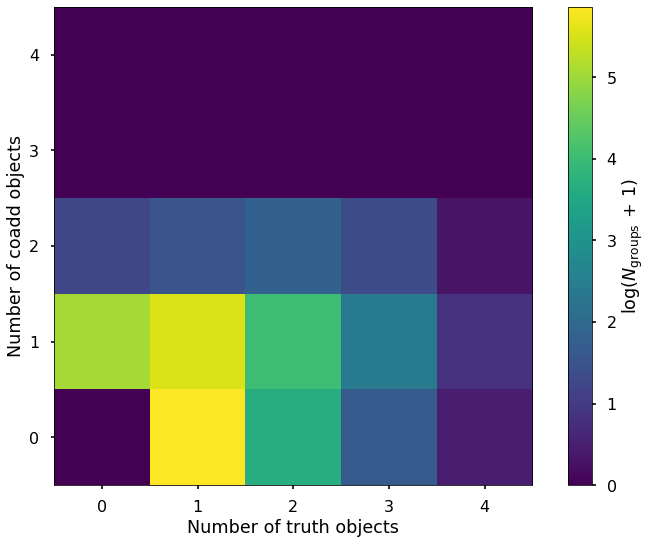

In [24]:
# now we want to count the number of truth and objects *for each group*
# but instead of looping over groups, we can do this in a smart (and very fast) way

# first we need to know which rows are from the truth catalog and which are from the coadd
truth_mask = results['catalog_key'] == 'truth'
object_mask = ~truth_mask

# then np.bincount will give up the number of id occurrences (like histogram but with integer input)
n_groups = results['group_id'].max() + 1
n_truth = np.bincount(results['group_id'][truth_mask], minlength=n_groups)
n_object = np.bincount(results['group_id'][object_mask], minlength=n_groups)

# now n_truth and n_coadd are the number of truth/coadd objects in each group
# we want to make a 2d histrogram of (n_truth, n_coadd). 
n_max = max(n_truth.max(), n_object.max()) + 1
hist_2d = np.bincount(n_object * n_max + n_truth, minlength=n_max*n_max).reshape(n_max, n_max)

plt.imshow(np.log10(hist_2d+1), extent=(-0.5, n_max-0.5, -0.5, n_max-0.5), origin='lower');
plt.xlabel('Number of truth objects');
plt.ylabel('Number of coadd objects');
plt.colorbar(label=r'$\log(N_{\rm groups} \, + \, 1)$');

In [25]:
# let's further inspect the objects in the groups that have 1-to-1 truth/coadd match.

# first, let's find our the IDs of the groups that have 1-to-1 truth/coadd match:
one_to_one_group_mask = np.in1d(results['group_id'], np.flatnonzero((n_truth == 1) & (n_object == 1)))

# and then we can find the row indices in the *original* truth/coadd catalogs for those 1-to-1 groups
truth_idx = results['row_index'][one_to_one_group_mask & truth_mask]
object_idx = results['row_index'][one_to_one_group_mask & object_mask]

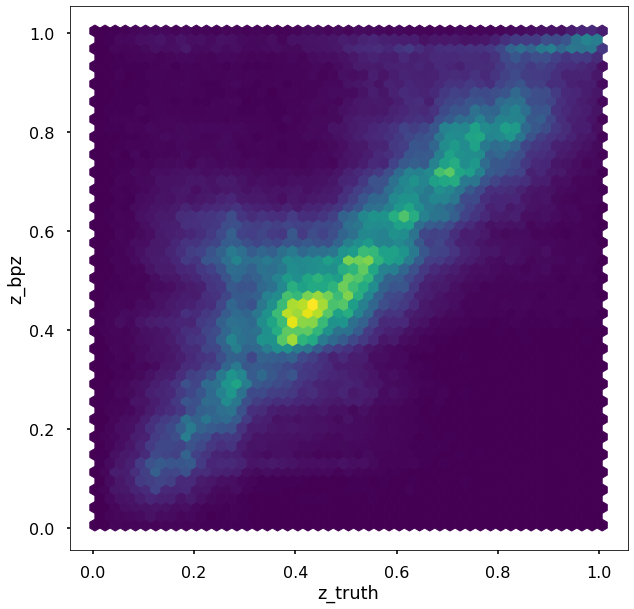

In [26]:
#z-z plot
plt.figure(figsize=(10,10))
plt.hexbin(truth_data['redshift'][truth_idx], joined_data['photoz_mode'][object_idx], gridsize=50)
plt.xlabel('z_truth')
plt.ylabel('z_bpz')
plt.show()

In [27]:
pdf_idx = joined_data['photoz_pdf_key'][object_idx]

In [28]:
top = np.trapz(object_cat.photoz_pdf_bin_centers*object_data['photoz_pdf'][pdf_idx].sum(axis=0), x=object_cat.photoz_pdf_bin_centers)
bottom = np.trapz(object_data['photoz_pdf'][pdf_idx].sum(axis=0), x=object_cat.photoz_pdf_bin_centers)
pzmean = top/bottom
histmean = truth_data['redshift'][truth_idx].mean()

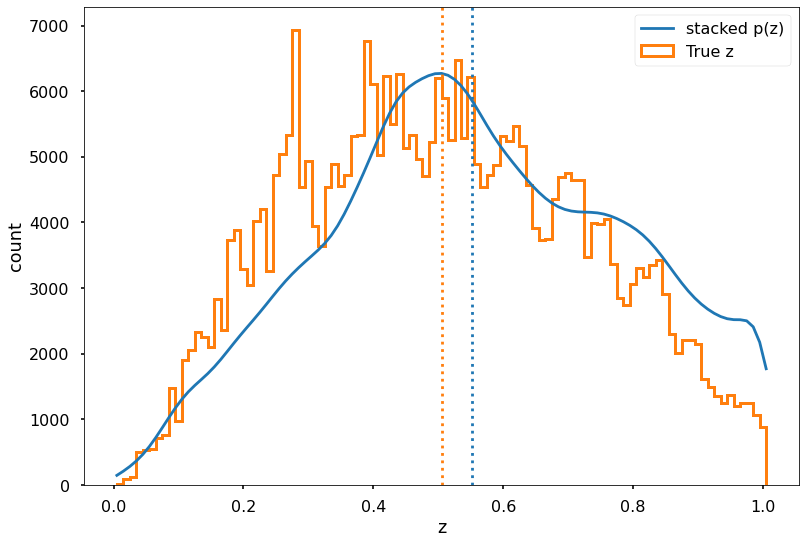

In [29]:
plt.plot(object_cat.photoz_pdf_bin_centers, object_data['photoz_pdf'][pdf_idx].sum(axis=0), label='stacked p(z)')
plt.hist(truth_data['redshift'][truth_idx], bins=object_cat.photoz_pdf_bin_centers, histtype='step', lw=3, label='True z');
plt.axvline(pzmean, ls=':', color='C0')
plt.axvline(histmean, ls=':', color='C1')
plt.xlabel('z')
plt.ylabel('count')
plt.legend()
plt.savefig('../plots/stacked-vs-true-1-1.png')

In [30]:
#courtesy Sam 
def fastCalcPIT(zgrid,pdf,sz):
    cdf = np.cumsum(pdf)
    idx = np.searchsorted(zgrid,sz,side='left')
    if sz <= zgrid[0]:
        return 0.0
    if sz >= zgrid[-1]:
        return 1.0
    y1,y2 = cdf[idx-1],cdf[idx]
    #print(f"ys: {y1},{y2}")
    x1,x2 = zgrid[idx-1],zgrid[idx]
    #print(f"xs: {x1},{x2}")
    delx = (sz-x1)*0.5
    if np.isclose(delx,0.0):
        return y1
    else:
        slope = (y2-y1)/(x2-x1)
        #print(f"slope: {slope}")
        finy = y1 + slope*delx
        return finy

In [31]:
#calculate PIT histogram
PITS = []
count = 0
for i, j, in zip(object_data['photoz_pdf'][pdf_idx], truth_data['redshift'][truth_idx]):
    pit = fastCalcPIT(object_cat.photoz_pdf_bin_centers,i,j)
    PITS.append(pit)
    count += 1
    if count % 100000 == 0:
        print(count)

100000
200000
300000


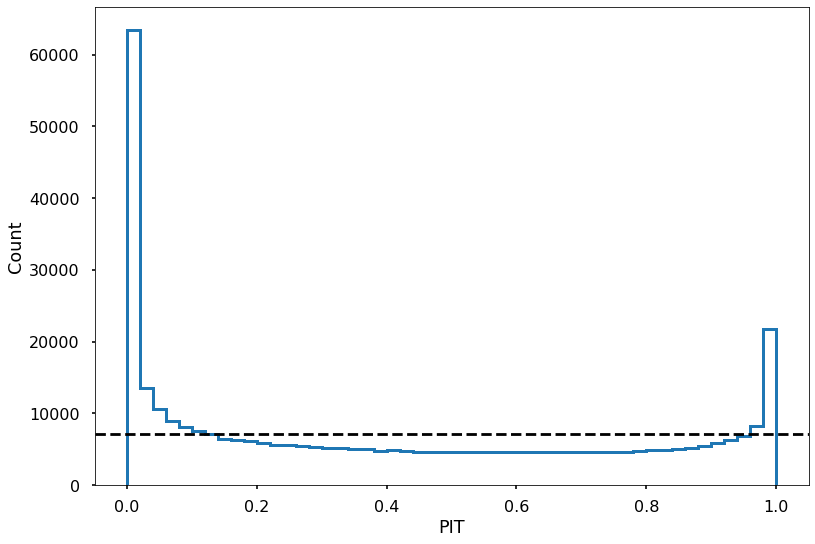

In [32]:
# PIT histogram for the entire sample, no tomographic binning 
plt.hist(PITS, bins=50, histtype='step', lw=3);
plt.xlabel('PIT')
plt.ylabel('Count')
numPIT = len(PITS)
plt.axhline(numPIT/50, ls='--', color='k')
plt.savefig('../plots/PIT-1-1.png')

In [33]:
# two to one match
two_to_one_group_mask = np.in1d(results['group_id'], np.flatnonzero((n_truth == 2) & (n_object == 1)))

# and then we can find the row indices in the *original* truth/coadd catalogs for those 1-to-1 groups
truth_idx = results['row_index'][two_to_one_group_mask & truth_mask]
object_idx = results['row_index'][two_to_one_group_mask & object_mask]

In [34]:
pdf_idx = joined_data['photoz_pdf_key'][object_idx]

In [35]:
top = np.trapz(object_cat.photoz_pdf_bin_centers*object_data['photoz_pdf'][pdf_idx].sum(axis=0), x=object_cat.photoz_pdf_bin_centers)
bottom = np.trapz(object_data['photoz_pdf'][pdf_idx].sum(axis=0), x=object_cat.photoz_pdf_bin_centers)
pzmean = top/bottom
histmean = truth_data['redshift'][truth_idx].mean()

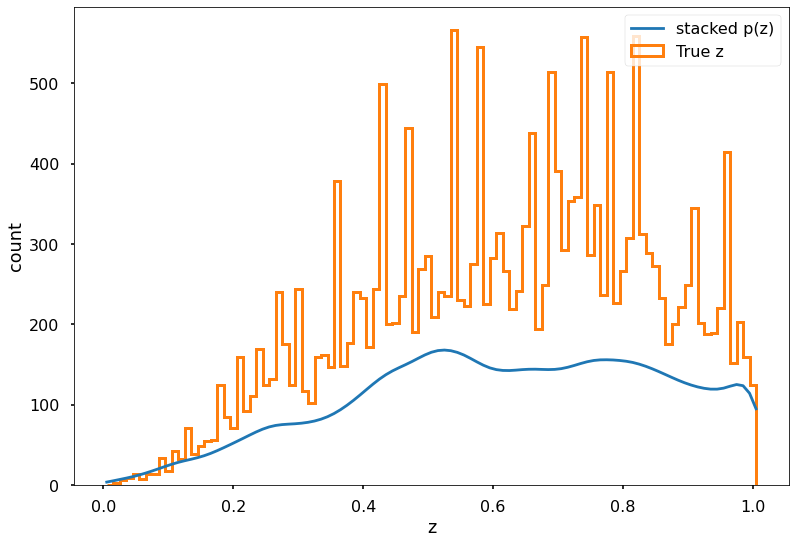

In [36]:
plt.plot(object_cat.photoz_pdf_bin_centers, object_data['photoz_pdf'][pdf_idx].sum(axis=0), label='stacked p(z)')
plt.hist(truth_data['redshift'][truth_idx], bins=object_cat.photoz_pdf_bin_centers, histtype='step', lw=3, label='True z');
plt.xlabel('z')
plt.ylabel('count')
plt.legend()
plt.savefig('../plots/stacked-vs-true-2-1.png')

In [37]:
bright_idx = []
i = 0
while i < (truth_idx.size - 1):
    if truth_data['mag_i'][truth_idx][i] > truth_data['mag_i'][truth_idx][i+1]:
        bright_idx.append(truth_idx[i+1])
    else:
        bright_idx.append(truth_idx[i])        
    i +=2

In [38]:
truth_data['mag_i'][truth_idx][:10]

array([19.3270688 , 20.55729269, 23.67649015, 22.97766209, 22.7945332 ,
       24.69403901, 22.22872939, 24.91766234, 17.19053238, 23.49368748])

In [39]:
truth_data['mag_i'][bright_idx][:5]

array([19.3270688 , 22.97766209, 22.7945332 , 22.22872939, 17.19053238])

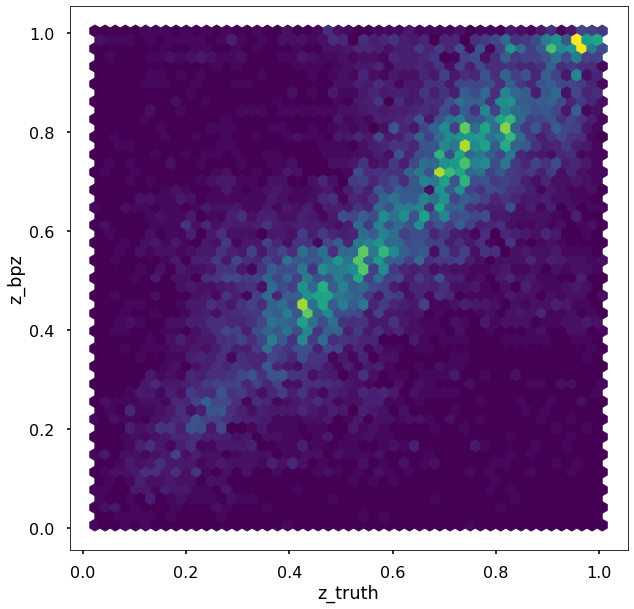

In [40]:
#z-z plot
plt.figure(figsize=(10,10))
plt.hexbin(truth_data['redshift'][bright_idx], joined_data['photoz_mode'][object_idx], gridsize=50)
plt.xlabel('z_truth')
plt.ylabel('z_bpz')
plt.show()

In [41]:
pdf_idx = joined_data['photoz_pdf_key'][object_idx]

In [42]:
top = np.trapz(object_cat.photoz_pdf_bin_centers*object_data['photoz_pdf'][pdf_idx].sum(axis=0), x=object_cat.photoz_pdf_bin_centers)
bottom = np.trapz(object_data['photoz_pdf'][pdf_idx].sum(axis=0), x=object_cat.photoz_pdf_bin_centers)
pzmean = top/bottom
histmean = truth_data['redshift'][bright_idx].mean()

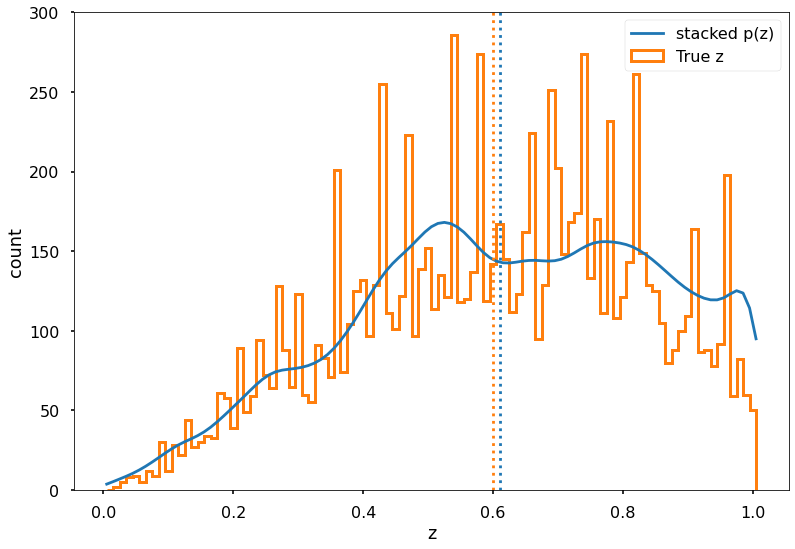

In [43]:
plt.plot(object_cat.photoz_pdf_bin_centers, object_data['photoz_pdf'][pdf_idx].sum(axis=0), label='stacked p(z)')
plt.hist(truth_data['redshift'][bright_idx], bins=object_cat.photoz_pdf_bin_centers, histtype='step', lw=3, label='True z');
plt.axvline(pzmean, ls=':', color='C0')
plt.axvline(histmean, ls=':', color='C1')
plt.xlabel('z')
plt.ylabel('count')
plt.legend()
plt.savefig('../plots/stacked-vs-true-2-1.png')

## Repeat Matching, but now making an arbitrary tomographic bin

In [44]:
tbin_mask = joined_data['photoz_mode'] > .4
tbin_mask &= joined_data['photoz_mode'] <= .6

In [45]:
joined['photoz_pdf'].values.sum()

KeyError: 'photoz_pdf'

In [ ]:
joined_data_tbin = {}

for k in joined_data.keys():
    print(k)
    joined_data_tbin[k] = joined_data[k][tbin_mask]

In [ ]:
results = FoFCatalogMatching.match(
    catalog_dict={'truth': truth_data, 'coadd': joined_data_tbin},
    linking_lengths=1.0,
    catalog_len_getter=lambda x: len(x['ra']),
)

In [ ]:
# now we want to count the number of truth and objects *for each group*
# but instead of looping over groups, we can do this in a smart (and very fast) way

# first we need to know which rows are from the truth catalog and which are from the coadd
truth_mask = results['catalog_key'] == 'truth'
object_mask = ~truth_mask

# then np.bincount will give up the number of id occurrences (like histogram but with integer input)
n_groups = results['group_id'].max() + 1
n_truth = np.bincount(results['group_id'][truth_mask], minlength=n_groups)
n_object = np.bincount(results['group_id'][object_mask], minlength=n_groups)

# now n_truth and n_coadd are the number of truth/coadd objects in each group
# we want to make a 2d histrogram of (n_truth, n_coadd). 
n_max = max(n_truth.max(), n_object.max()) + 1
hist_2d = np.bincount(n_object * n_max + n_truth, minlength=n_max*n_max).reshape(n_max, n_max)

plt.imshow(np.log10(hist_2d+1), extent=(-0.5, n_max-0.5, -0.5, n_max-0.5), origin='lower');
plt.xlabel('Number of truth objects');
plt.ylabel('Number of coadd objects');
plt.colorbar(label=r'$\log(N_{\rm groups} \, + \, 1)$');

In [ ]:
# let's further inspect the objects in the groups that have 1-to-1 truth/coadd match.

# first, let's find our the IDs of the groups that have 1-to-1 truth/coadd match:
one_to_one_group_mask = np.in1d(results['group_id'], np.flatnonzero((n_truth == 1) & (n_object == 1)))

# and then we can find the row indices in the *original* truth/coadd catalogs for those 1-to-1 groups
truth_idx = results['row_index'][one_to_one_group_mask & truth_mask]
object_idx = results['row_index'][one_to_one_group_mask & object_mask]

In [ ]:
#z-z plot
plt.figure(figsize=(10,7))
plt.hexbin(truth_data['redshift'][truth_idx], joined_data_tbin['photoz_mode'][object_idx], gridsize=20)
plt.xlabel('z_truth')
plt.ylabel('z_bpz')
plt.show()

In [ ]:
pdf_idx = joined_data_tbin['photoz_pdf_key'][object_idx]

In [ ]:
top = np.trapz(object_cat.photoz_pdf_bin_centers*object_data['photoz_pdf'][pdf_idx].sum(axis=0), x=object_cat.photoz_pdf_bin_centers)
bottom = np.trapz(object_data['photoz_pdf'][pdf_idx].sum(axis=0), x=object_cat.photoz_pdf_bin_centers)
pzmean = top/bottom
histmean = truth_data['redshift'][truth_idx].mean()

In [ ]:
plt.plot(object_cat.photoz_pdf_bin_centers, object_data['photoz_pdf'][pdf_idx].sum(axis=0), label='stacked p(z)')
plt.hist(truth_data['redshift'][truth_idx], bins=object_cat.photoz_pdf_bin_centers, histtype='step', lw=3, label='True z');
plt.axvline(pzmean, ls=':', color='C0')
plt.axvline(histmean, ls=':', color='C1')
plt.xlabel('z')
plt.ylabel('count')
plt.savefig('../plots/stacked-vs-true-1-1-z4-6.png')
plt.legend()

In [ ]:
PITS = []
count = 0
for i, j, in zip(object_data['photoz_pdf'][pdf_idx], truth_data['redshift'][truth_idx]):
    pit = fastCalcPIT(object_cat.photoz_pdf_bin_centers,i,j)
    PITS.append(pit)
    count += 1
    if count % 100000 == 0:
        print(count)

In [ ]:
# PIT histogram for the entire sample, no tomographic binning 
plt.hist(PITS, bins=50, histtype='step', lw=3);
plt.xlabel('PIT')
plt.ylabel('Count')
numPIT = len(PITS)
plt.axhline(numPIT/50, ls='--', color='k')
plt.savefig('../plots/PIT-1-1-z4-6.png')